In [1]:
!pip install pyspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("CreditCardAnomalyDetection").getOrCreate()
df = spark.read.csv('/content/creditcard_data.csv', header='True', inferSchema='True')


In [4]:


# Only cache the relevant DataFrames
df = df.drop("Time")
df = df.withColumnRenamed("Class", "label")
df = df.select([col(c).cast("double").alias(c) for c in df.columns])
(trainingData, testData) = df.repartition(2).cache().randomSplit([0.7, 0.3], seed=100)


# Specify the relevant column names for VectorAssembler
assembler = VectorAssembler(inputCols=["V" + str(i) for i in range(1, 29)], outputCol="features")

# Fit the scaler only on trainingData and transform both trainingData and testData
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, scaler])
trainingData = pipeline.fit(trainingData.repartition(2).cache()).transform(trainingData)
testData = pipeline.fit(testData.repartition(2).cache()).transform(testData)


# Use a simpler metric for the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

lr = LogisticRegression(labelCol="label", featuresCol="features")
lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "label", "features").show()
lr_accuracy = evaluator.evaluate(lr_prediction)
print("Accuracy of LogisticRegression is = %g"% (lr_accuracy))
print("Test Error of LogisticRegression = %g " % (1.0 - lr_accuracy))

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_model = dt.fit(trainingData)
dt_prediction = dt_model.transform(testData)
dt_prediction.select("prediction", "label", "features").show()
dt_accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy of DecisionTreeClassifier is = %g"% (dt_accuracy))
print("Test Error of DecisionTreeClassifier = %g " % (1.0 - dt_accuracy))

rf = RandomForestClassifier()
rf_model = rf.fit(trainingData)
rf_prediction = rf_model.transform(testData)
rf_prediction.select("prediction", "label", "features").show()
rf_accuracy = evaluator.evaluate(rf_prediction)
print("Accuracy of RandomForestClassifier is = %g"% (rf_accuracy))
print("Test Error of RandomForestClassifier  = %g " % (1.0 - rf_accuracy))


+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[-35.69834466,-33...|
|       0.0|  0.0|[-31.74666256,17....|
|       0.0|  0.0|[-31.32289536,-30...|
|       0.0|  0.0|[-30.51545511,-32...|
|       0.0|  1.0|[-29.20032859,16....|
|       0.0|  0.0|[-28.22207649,-33...|
|       0.0|  0.0|[-27.08329175,-21...|
|       0.0|  0.0|[-26.25768917,-33...|
|       0.0|  0.0|[-25.37438637,-4....|
|       0.0|  0.0|[-24.71717867,-29...|
|       0.0|  0.0|[-24.32175587,-20...|
|       0.0|  0.0|[-23.91742439,-19...|
|       0.0|  0.0|[-23.78218513,-34...|
|       0.0|  0.0|[-23.57100292,-22...|
|       0.0|  0.0|[-23.42035881,-6....|
|       0.0|  0.0|[-22.62659209,-21...|
|       0.0|  0.0|[-22.28496652,4.5...|
|       0.0|  0.0|[-21.56741928,-20...|
|       0.0|  0.0|[-21.54695869,4.3...|
|       0.0|  0.0|[-21.35305622,-8....|
+----------+-----+--------------------+
only showing top 20 rows

Accuracy of Lo

In [5]:
ytest = testData.select("label").toPandas()
lr_pred_label = lr_prediction.select("label").toPandas()
rf_pred_label = rf_prediction.select("label").toPandas()

In [6]:

cm = np.array(confusion_matrix(ytest,lr_pred_label, labels=[1,0]))
confusion_lr = pd.DataFrame(cm, index=['is Fraud', 'is Normal'],columns=['predicted fraud','predicted normal'])
confusion_lr

,predicted fraud,predicted normal
is Fraud,159,0
is Normal,0,85349


<Axes: >

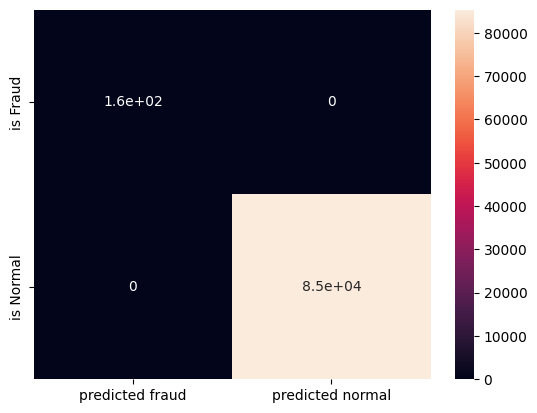

In [7]:
sns.heatmap(confusion_lr, annot=True)

In [8]:
cm = np.array(confusion_matrix(ytest,rf_pred_label, labels=[1,0]))
confusion_rf = pd.DataFrame(cm, index=['is Fraud', 'is Normal'],columns=['predicted fraud','predicted normal'])
confusion_rf

,predicted fraud,predicted normal
is Fraud,159,0
is Normal,0,85349


<Axes: >

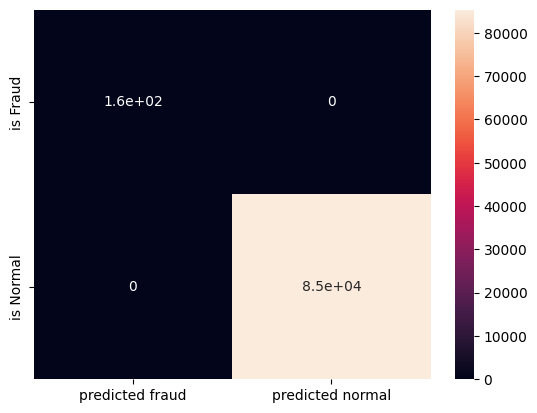

In [9]:
sns.heatmap(confusion_rf, annot=True)

In [10]:
print(classification_report(ytest, lr_pred_label))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85349
         1.0       1.00      1.00      1.00       159

    accuracy                           1.00     85508
   macro avg       1.00      1.00      1.00     85508
weighted avg       1.00      1.00      1.00     85508



In [11]:
print(classification_report(ytest, rf_pred_label))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85349
         1.0       1.00      1.00      1.00       159

    accuracy                           1.00     85508
   macro avg       1.00      1.00      1.00     85508
weighted avg       1.00      1.00      1.00     85508

